In [ ]:
from google.colab import drive
import zipfile
import os
import shutil
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Collect photo

In [ ]:
path = '/content/drive/MyDrive/emotions_dataset/KDEF.zip'
zip_object = zipfile.ZipFile(path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
# Для кожної фотографії визначається емоція на основі назви файлу
path = '/content/KDEF'
root_directory = '/content/KDEF'
emotions_directory = '/content/drive/MyDrive/emotions_dataset/KDEF_all'

if not os.path.exists(emotions_directory):
    os.makedirs(emotions_directory)
emotions = {
    'AF': 'afraid',
    'AN': 'angry',
    'DI': 'disgusted',
    'HA': 'happy',
    'NE': 'neutral',
    'SA': 'sad',
    'SU': 'surprised'
}
# Словник для зберігання даних: ключ - шлях до фото, значення - емоція
photo_emotions = {}

for person_folder in os.listdir(root_directory):
    person_path = os.path.join(root_directory, person_folder)
    if os.path.isdir(person_path):
        for photo_filename in os.listdir(person_path):
            photo_path = os.path.join(person_path, photo_filename)
            _, file_extension = os.path.splitext(photo_path)
            if file_extension.lower() in ['.jpg', '.jpeg']:
              emotion_code = photo_filename[4:6]
              print(emotion_code)
              print(photo_path)
              photo_emotions[photo_path] = emotions[emotion_code]



In [ ]:
# перебір всіх фотографій в кореневій папці та видалення тих, назва яких закінчується на 'FR' або 'FL' (фронтальна позиція праворуч або фронтальна позиція ліворуч)
root_directory = '/content/drive/MyDrive/emotions_dataset/KDEF_all'
# Перебір папок (людей) у кореневій директорії
for emotion_folder in os.listdir(root_directory):
    emotion_path = os.path.join(root_directory, emotion_folder)
    for photo_filename in os.listdir(emotion_path):
      photo_path = os.path.join(emotion_path, photo_filename)
      print(photo_path)
      name_file, file_extension = os.path.splitext(photo_filename)
      if name_file[-2:] == 'FR' or name_file[-2:] == 'FL':
        os.remove(photo_path)


In [ ]:
# Перебір словника та копіювання фото у відповідні папки емоцій
for photo_path, emotion_code in photo_emotions.items():
    emotion_path = os.path.join(emotions_directory, emotion_code)
    # Створення папки емоції, якщо вона ще не існує
    if not os.path.exists(emotion_path):
        os.makedirs(emotion_path)
    # Копіювання фото у папку емоції
    shutil.copy(photo_path, emotion_path)

print(f"Фотографії були успішно відсортовані за емоціями у папку: {emotions_directory}")

Фотографії були успішно відсортовані за емоціями у папку: /content/drive/MyDrive/emotions_dataset/KDEF_all


In [ ]:
path = '/content/KDEF'
root_directory = '/content/drive/MyDrive/emotions_dataset/KDEF_all'

# Словник для зберігання даних: ключ - шлях до фото, значення - емоція
photo_paths = []

# Перебір папок (людей) у кореневій директорії
for emotion_folder in os.listdir(root_directory):
    emotion_path = os.path.join(root_directory, emotion_folder)
    for photo_filename in os.listdir(emotion_path):
      photo_path = os.path.join(emotion_path, photo_filename)
      photo_paths.append((photo_path, emotion_folder))



## Create features

In [ ]:
# процес детекції обличчя та знаходження ключових точок (лендмарків) на зображеннях облич
landmarks_all = []
emotions = []
predictor_path = '/content/drive/MyDrive/emotions_dataset/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
# Завантаження попередньо навченої моделі для детекції лендмарків
predictor = dlib.shape_predictor(predictor_path)

for image_path, emotion in photo_paths:

  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = detector(gray, 1)

  for (i, face) in enumerate(faces):
      landmarks = predictor(gray, face)
      landmarks_all.append(landmarks)
      emotions.append(emotion)

In [ ]:
# розрахунок геометричних величин (відстаней і кутів) між точками
def calculate_distance(point1, point2):
  point1 = (point1.x, point1.y)
  point2 = (point2.x, point2.y)
  return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_angle(point1, point2, point3):
    """Розрахунок кута між трьома точками, p2 - вершина кута."""
    point1 = (point1.x, point1.y)
    point2 = (point2.x, point2.y)
    point3 = (point3.x, point3.y)
    p1 = np.array(point1)
    p2 = np.array(point2)
    p3 = np.array(point3)
    ba = p1 - p2
    bc = p3 - p2

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

In [ ]:
landmarks_all[0].part(0), landmarks_all[0].part(1)

(point(105, 393), point(92, 417))

In [ ]:
# обчислення ознак
features = []
for i in range(len(landmarks_all)):
  # Ознака 1: Відстань між куточками рота
  distance_mouth_corners = calculate_distance(landmarks_all[i].part(48), landmarks_all[i].part(54))

  # Ознака 2: Відстань між бровами
  distance_eyebrows = calculate_distance(landmarks_all[i].part(21), landmarks_all[i].part(22))

  # Ознака 3: Відстань між верхньою губою і носом
  distance_nose_to_upper_lip = calculate_distance(landmarks_all[i].part(33), landmarks_all[i].part(51))

  # Ознака 4: Кут нахилу брів (беремо три точки для брови, щоб визначити кут)
  angle_left_eyebrow = calculate_angle(landmarks_all[i].part(17), landmarks_all[i].part(19), landmarks_all[i].part(21))
  angle_right_eyebrow = calculate_angle(landmarks_all[i].part(22), landmarks_all[i].part(24), landmarks_all[i].part(26))

  # Ознака 5: Відкриття очей (відстань між верхнім і нижнім віком)
  left_eye_opening = calculate_distance(landmarks_all[i].part(37), landmarks_all[i].part(41))
  right_eye_opening = calculate_distance(landmarks_all[i].part(44), landmarks_all[i].part(46))

  # Ознака 6: Ширина носа (відстань між крилами носа)
  nose_width = calculate_distance(landmarks_all[i].part(31), landmarks_all[i].part(35))

  # Ознака 7: Відстань між бровою і верхньою частиною віка для кожного ока
  distance_eyebrow_upper_eyelid_left = calculate_distance(landmarks_all[i].part(20), landmarks_all[i].part(37))
  distance_eyebrow_upper_eyelid_right = calculate_distance(landmarks_all[i].part(23), landmarks_all[i].part(44))

  # Ознака 8: Висота рота (відстань між верхньою та нижньою губами)
  mouth_height = calculate_distance(landmarks_all[i].part(51), landmarks_all[i].part(57))

  # Ознака 9: Відстані між кінчиком носа і кожним куточком рота
  nose_tip_to_mouth_corner_left = calculate_distance(landmarks_all[i].part(33), landmarks_all[i].part(48))
  nose_tip_to_mouth_corner_right = calculate_distance(landmarks_all[i].part(33), landmarks_all[i].part(54))

  # Ознака 10: Відстань між центром очей і куточками рота
  eyes_center_to_mouth_left = calculate_distance(landmarks_all[i].part(40), landmarks_all[i].part(48))
  eyes_center_to_mouth_right = calculate_distance(landmarks_all[i].part(47), landmarks_all[i].part(54))

  features.append([distance_mouth_corners, distance_eyebrows, distance_nose_to_upper_lip, angle_left_eyebrow, angle_right_eyebrow, left_eye_opening, right_eye_opening,
                   nose_width, distance_eyebrow_upper_eyelid_left, distance_eyebrow_upper_eyelid_right, mouth_height, nose_tip_to_mouth_corner_left,
                   nose_tip_to_mouth_corner_right, eyes_center_to_mouth_left, eyes_center_to_mouth_right])

In [ ]:
len(features[0])

15

In [ ]:
with open('features.npy', 'wb') as f:
    np.save(f, features)

In [ ]:
with open('emotions.npy', 'wb') as f:
    np.save(f, emotions)

## Model training

In [ ]:
X = np.asarray(features)
y = np.asarray(emotions)

In [ ]:
X.shape

(2929, 15)

In [ ]:
y.shape

(2929,)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Кодування цільової змінної
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [ ]:
encoder.categories_

[array(['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad',
        'surprised'], dtype='<U9')]

In [ ]:
# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 128)               2048      
                                                                 
 dropout_47 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 32)                2080      
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_72 (Dense)            (None, 7)               

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=80, batch_size=16, callbacks=[callback])

Epoch 1/80
147/147 [==============================] - 2s 5ms/step - loss: 1.5050 - accuracy: 0.4238 - val_loss: 0.9362 - val_accuracy: 0.6980
Epoch 2/80
147/147 [==============================] - 0s 3ms/step - loss: 1.0345 - accuracy: 0.6253 - val_loss: 0.7730 - val_accuracy: 0.7270
Epoch 3/80
147/147 [==============================] - 0s 3ms/step - loss: 0.8837 - accuracy: 0.6765 - val_loss: 0.7097 - val_accuracy: 0.7253
Epoch 4/80
147/147 [==============================] - 0s 3ms/step - loss: 0.8581 - accuracy: 0.6786 - val_loss: 0.6744 - val_accuracy: 0.7491
Epoch 5/80
147/147 [==============================] - 0s 3ms/step - loss: 0.8127 - accuracy: 0.6940 - val_loss: 0.6812 - val_accuracy: 0.7389
Epoch 6/80
147/147 [==============================] - 0s 3ms/step - loss: 0.7886 - accuracy: 0.7072 - val_loss: 0.6507 - val_accuracy: 0.7526
Epoch 7/80
147/147 [==============================] - 0s 3ms/step - loss: 0.7641 - accuracy: 0.7166 - val_loss: 0.6377 - val_accuracy: 0.7474
Epoch 

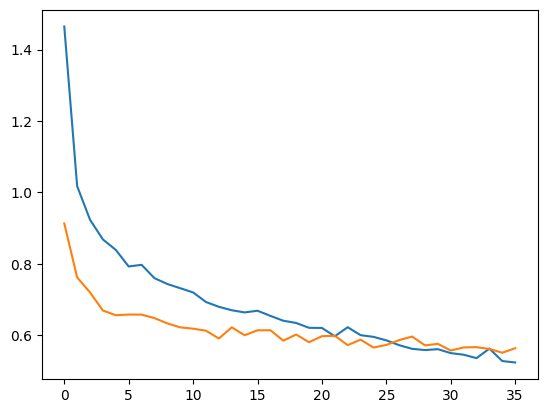

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Model testing

In [ ]:
predictions = model.predict(X_test)

19/19 [==============================] - 0s 2ms/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

# Створюємо One-Hot вектори для прогнозованих класів
predicted_one_hot = np.eye(7)[predicted_classes]

In [ ]:
print(classification_report(y_test, predicted_one_hot))

              precision    recall  f1-score   support

           0       0.76      0.43      0.55        81
           1       0.76      0.81      0.78        83
           2       0.87      0.75      0.81        92
           3       0.96      0.97      0.96        89
           4       0.77      0.82      0.79        82
           5       0.61      0.78      0.68        73
           6       0.77      0.92      0.84        86

   micro avg       0.78      0.78      0.78       586
   macro avg       0.79      0.78      0.77       586
weighted avg       0.79      0.78      0.78       586
 samples avg       0.78      0.78      0.78       586



In [ ]:
model.save('my_model.h5')